/var/folders/ty/kkyy7c9s4059czrtyxg_0mz40000gn/T/ipykernel_41865/1280010114.py:56: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(pd.Grouper(freq="M"))["author"])


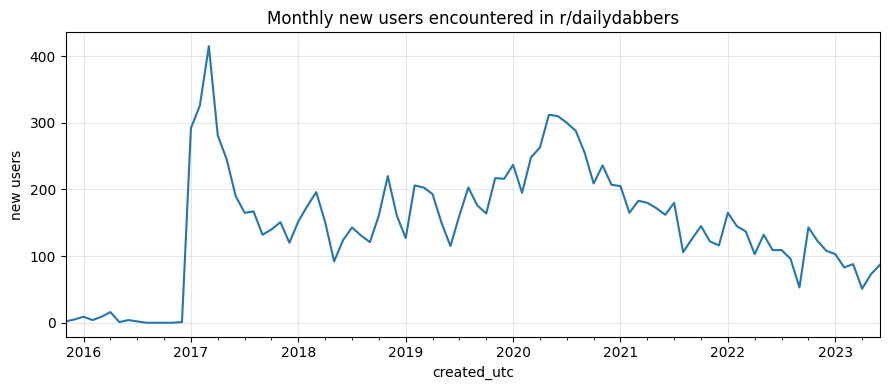

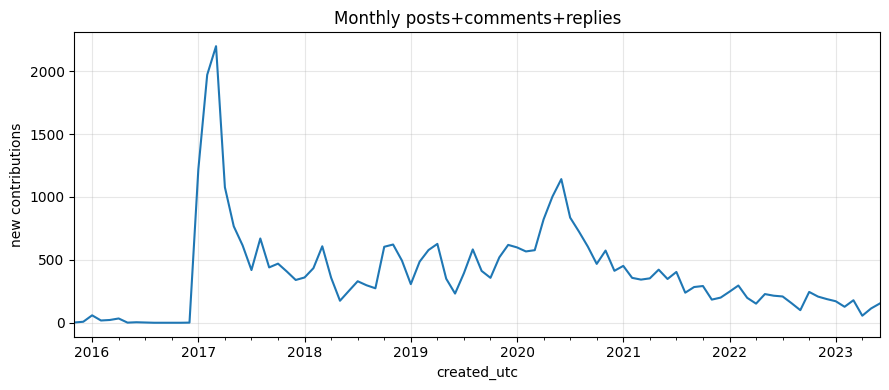

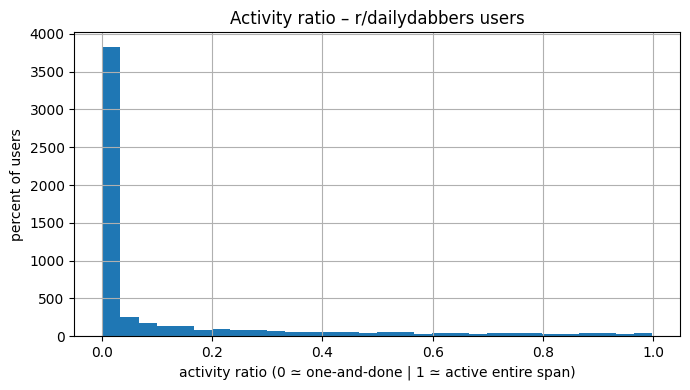

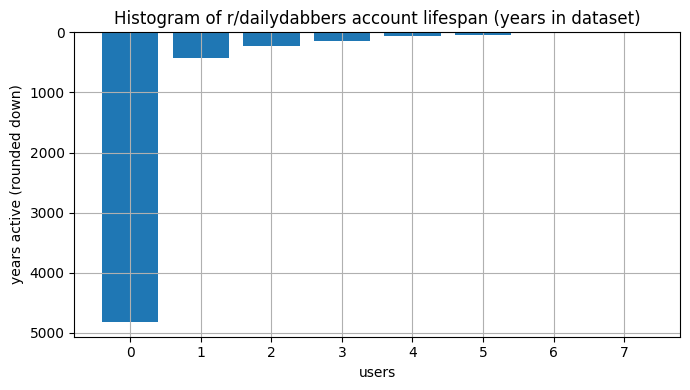

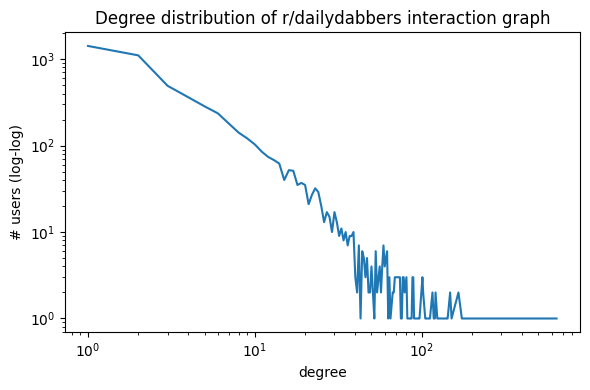

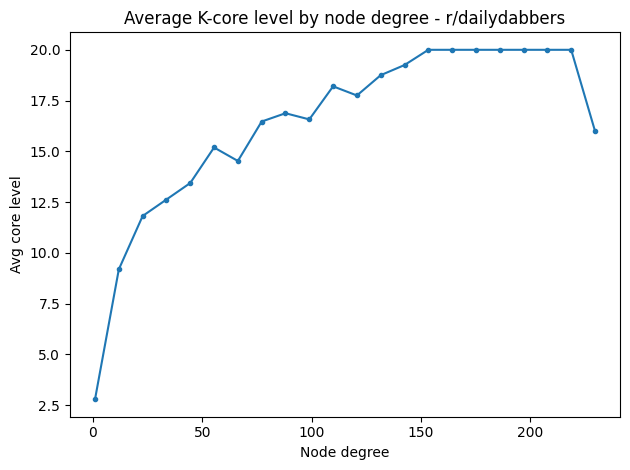


Summary
  • unique users  : 5,756
  • total rows    : 36,472
  • graph nodes   : 5,427
  • graph edges   : 21,623
  • avg degree    : 7.97
  • reciprocity   : 0.520
  • assortativity : -0.0576


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# ────────────────────────────
# 0.  CONFIG
# ────────────────────────────
CSV_PATH = Path(
    "/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/"
    "CSV for mass database organization/R:DailyDabbers/Combined Daily Dabbers W Network/"
    "r_dailydabbers_network.csv"
)

CUTOFF = pd.Timestamp("2023-06-30 23:59:59", tz="UTC")   # end of Q2-2023

# ────────────────────────────
# 1.  LOAD  +  TRUNCATE
# ────────────────────────────
df = (
    pd.read_csv(CSV_PATH,
                usecols=["author", "created_utc", "node_type",
                         "parent_id", "id"],
                dtype=str)
    .query("author not in ['[deleted]', '[removed]']")
)
df["created_utc"] = pd.to_datetime(df["created_utc"].astype(int),
                                   unit="s", utc=True)

df = df[df["created_utc"] <= CUTOFF].copy()

# ────────────────────────────
# 1.  LOAD  +  TRUNCATE
# ────────────────────────────
df = (
    pd.read_csv(CSV_PATH,
                usecols=["author", "created_utc", "node_type",
                         "parent_id", "id"],
                dtype=str)
    .query("author not in ['[deleted]', '[removed]']")
)
df["created_utc"] = pd.to_datetime(df["created_utc"].astype(int),
                                   unit="s", utc=True)

df = df[df["created_utc"] <= CUTOFF].copy()

# ────────────────────────────
# 2–8. SAME AS ORIGINAL SCRIPT
# (continue running everything as-is below this point)
# ────────────────────────────
# 2.  MONTHLY NEW USERS
# ────────────────────────────
by_month = (df
            .set_index("created_utc")
            .groupby(pd.Grouper(freq="M"))["author"])

cum_users = by_month.nunique().cumsum()
new_users = cum_users.diff().fillna(cum_users)

ax = new_users.plot(figsize=(9, 4))
ax.set_title("Monthly new users encountered in r/dailydabbers")
ax.set_ylabel("new users")
ax.grid(alpha=.3)
plt.tight_layout(); plt.show()

# ────────────────────────────
# 3.  MONTHLY CONTRIBUTIONS
# ────────────────────────────
monthly_rows = by_month.size()
monthly_rows.plot(figsize=(9, 4), title="Monthly posts+comments+replies")
plt.ylabel("new contributions"); plt.grid(alpha=.3)
plt.tight_layout(); plt.show()

# ────────────────────────────
# 4.  ACTIVITY-RATIO
# ────────────────────────────
dataset_end = CUTOFF

first_last = df.groupby("author")["created_utc"].agg(["min", "max"])
numer  = (first_last["max"] - first_last["min"]).dt.total_seconds()
denom  = (dataset_end         - first_last["min"]).dt.total_seconds()
activity_ratio = (numer / denom).fillna(0).clip(0, 1)

plt.figure(figsize=(7, 4))
activity_ratio.hist(bins=30)
plt.title("Activity ratio – r/dailydabbers users")
plt.xlabel("activity ratio (0 ≃ one-and-done | 1 ≃ active entire span)")
plt.ylabel("percent of users")
plt.tight_layout(); plt.show()

# ────────────────────────────
# 5.  ACCOUNT LIFESPAN
# ────────────────────────────
age_years = ((first_last["max"] - first_last["min"]).dt.days / 365)\
              .clip(0).astype(int)
age_years.hist(bins=np.arange(0, age_years.max()+2)-0.5,
               rwidth=.8, figsize=(7, 4))
plt.gca().invert_yaxis()
plt.title("Histogram of r/dailydabbers account lifespan (years in dataset)")
plt.xlabel("users"); plt.ylabel("years active (rounded down)")
plt.tight_layout(); plt.show()

# ────────────────────────────
# 6.  INTERACTION GRAPH  &  DEGREE DISTRO
# ────────────────────────────
parent_author = dict(zip(df["id"], df["author"]))
edges = (df[df["parent_id"].notna() & df["parent_id"].str.len() > 0]
         .apply(lambda r: (parent_author.get(r["parent_id"]), r["author"]),
                axis=1))
edges = [(src, dst) for src, dst in edges if src and dst and src != dst]

G = nx.DiGraph();  G.add_edges_from(edges)

deg_series = pd.Series(dict(G.degree()))
plt.figure(figsize=(6, 4))
deg_series.value_counts().sort_index().plot(loglog=True)
plt.title("Degree distribution of r/dailydabbers interaction graph")
plt.xlabel("degree"); plt.ylabel("# users (log-log)")
plt.tight_layout(); plt.show()

# ────────────────────────────
# 7.  K-CORE vs. DEGREE
# ────────────────────────────
core = pd.Series(nx.core_number(G))
deg  = deg_series

bins = np.linspace(1, deg.max(), 60)
digit = np.digitize(deg, bins)
avg_core = core.groupby(digit).mean()
mid_deg  = pd.Series(bins).groupby(np.arange(len(bins))).mean()

plt.plot(mid_deg[:len(avg_core)], avg_core, marker='.')
plt.title("Average K-core level by node degree - r/dailydabbers")
plt.xlabel("Node degree"); plt.ylabel("Avg core level")
plt.tight_layout(); plt.show()

# ────────────────────────────
# 8.  SUMMARY
# ────────────────────────────
print("\nSummary")
print(f"  • unique users  : {df['author'].nunique():,}")
print(f"  • total rows    : {len(df):,}")
print(f"  • graph nodes   : {G.number_of_nodes():,}")
print(f"  • graph edges   : {G.number_of_edges():,}")
print(f"  • avg degree    : {deg.mean():.2f}")
print(f"  • reciprocity   : {nx.reciprocity(G):.3f}")
print(f"  • assortativity : {nx.degree_assortativity_coefficient(G):.4f}")



/var/folders/ty/kkyy7c9s4059czrtyxg_0mz40000gn/T/ipykernel_77531/474520549.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["quarter"] = df["created_utc"].dt.to_period("Q")


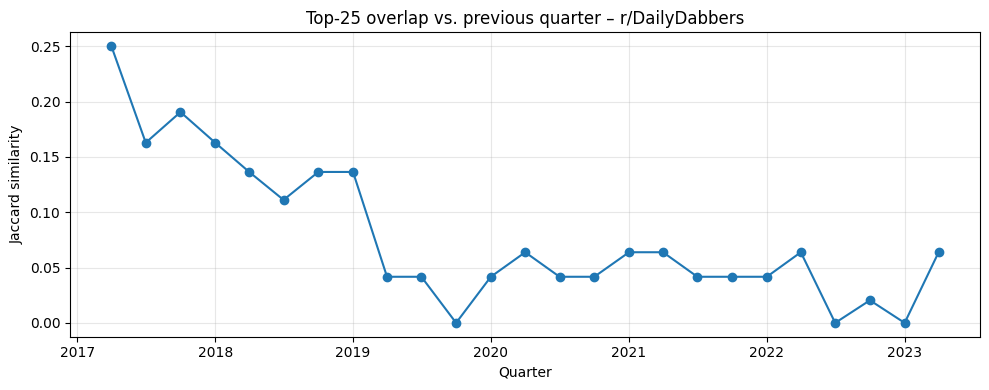

In [11]:
from matplotlib import pyplot as plt
import pandas as pd
import networkx as nx

# ────────────────────────────
# 1. Assign QUARTER
# ────────────────────────────
df["quarter"] = df["created_utc"].dt.to_period("Q")

# ────────────────────────────
# 2. Compute Top-25 PageRank Users per Quarter
# ────────────────────────────
records = []

for q, q_df in df.groupby("quarter"):
    if len(q_df) < 300:  # skip tiny quarters
        continue

    G = build_graph_slice(q_df)
    pr = nx.pagerank(G, alpha=0.85)
    top25 = sorted(pr, key=pr.get, reverse=True)[:25]
    
    for u in top25:
        records.append({"quarter": q, "author": u, "pr": pr[u]})

top_df = pd.DataFrame(records)

# ────────────────────────────
# 3. Compute Pairwise Jaccard Overlap between Quarters
# ────────────────────────────
groups = list(top_df.groupby("quarter"))
overlaps = []

for (q1, g1), (q2, g2) in zip(groups[:-1], groups[1:]):
    s1 = set(g1["author"])
    s2 = set(g2["author"])
    jaccard = len(s1 & s2) / len(s1 | s2)
    overlaps.append({"quarter_2": q2.to_timestamp(), "jaccard": jaccard})

overlap_df = pd.DataFrame(overlaps)

# ────────────────────────────
# 4. Plot
# ────────────────────────────
plt.figure(figsize=(10, 4))
plt.plot(overlap_df["quarter_2"], overlap_df["jaccard"], marker="o", label="jaccard")
plt.title("Top-25 overlap vs. previous quarter – r/DailyDabbers")
plt.ylabel("Jaccard similarity")
plt.xlabel("Quarter")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


/var/folders/ty/kkyy7c9s4059czrtyxg_0mz40000gn/T/ipykernel_77531/1181086767.py:25: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["quarter"] = df["created_utc"].dt.to_period("Q")


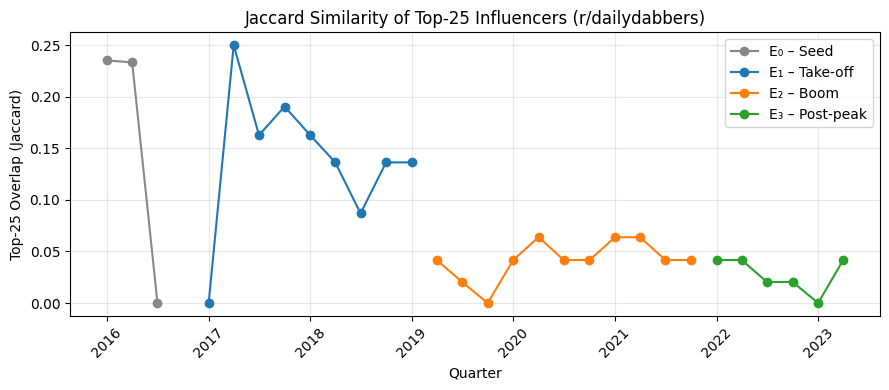


Transition Matrix of Influencer Roles (r/dailydabbers):
            core  periphery  absent
core       0.142      0.343   0.515
periphery  0.019      0.242   0.739
absent     0.003      0.047   0.951


In [12]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# ─────────────────────────────
# Epoch labeling function
# ─────────────────────────────
def assign_epoch(date):
    if pd.Timestamp("2015-01-01") <= date <= pd.Timestamp("2016-12-31"):
        return "E₀ – Seed"
    elif pd.Timestamp("2017-01-01") <= date <= pd.Timestamp("2019-03-31"):
        return "E₁ – Take-off"
    elif pd.Timestamp("2019-04-01") <= date <= pd.Timestamp("2021-12-31"):
        return "E₂ – Boom"
    elif pd.Timestamp("2022-01-01") <= date <= pd.Timestamp("2023-06-30"):
        return "E₃ – Post-peak"
    else:
        return None

# ─────────────────────────────
# 1. Build quarterly graphs & top-25 PageRank
# ─────────────────────────────
df["quarter"] = df["created_utc"].dt.to_period("Q")
quarters = sorted(df["quarter"].unique())
parent_map = dict(zip(df["id"], df["author"]))

top25_by_q = {}
for q in quarters:
    dfi = df[df["quarter"] == q]
    edges = (dfi[dfi["parent_id"].notna()]
             .apply(lambda r: (parent_map.get(r["parent_id"]), r["author"]), axis=1))
    edges = [(a, b) for a, b in edges if a and b and a != b]
    G = nx.DiGraph()
    G.add_edges_from(edges)
    if len(G) > 0:
        pr = nx.pagerank(G)
        top25 = sorted(pr.items(), key=lambda x: -x[1])[:25]
        top25_by_q[q] = set([u for u, _ in top25])

# ─────────────────────────────
# 2. Jaccard Similarity Between Quarters
# ─────────────────────────────
def jaccard(a, b):
    return len(a & b) / len(a | b) if a | b else np.nan

q_list = list(top25_by_q.keys())
jaccard_scores = [jaccard(top25_by_q[q1], top25_by_q[q2]) for q1, q2 in zip(q_list[:-1], q_list[1:])]
jaccard_df = pd.DataFrame({
    "quarter": [q.to_timestamp() for q in q_list[1:]],
    "jaccard": jaccard_scores
})
jaccard_df["epoch"] = jaccard_df["quarter"].apply(assign_epoch)

# ─────────────────────────────
# 3. Plot Jaccard Similarity by Epoch
# ─────────────────────────────
epoch_colors = {
    "E₀ – Seed": "#888",
    "E₁ – Take-off": "#1f77b4",
    "E₂ – Boom": "#ff7f0e",
    "E₃ – Post-peak": "#2ca02c"
}

plt.figure(figsize=(9, 4))
for label, group in jaccard_df.groupby("epoch"):
    plt.plot(group["quarter"], group["jaccard"], marker='o', label=label,
             color=epoch_colors.get(label, "#333"))
plt.title("Jaccard Similarity of Top-25 Influencers (r/dailydabbers)")
plt.ylabel("Top-25 Overlap (Jaccard)")
plt.xlabel("Quarter")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ─────────────────────────────
# 4. Role Transitions: Core / Periphery / Absent
# ─────────────────────────────
all_users = set(df["author"].unique())
role_by_q = {}

for q in q_list:
    present_users = set(df[df["quarter"] == q]["author"])
    core = top25_by_q.get(q, set())
    periphery = present_users - core
    absent = all_users - present_users
    role_by_q[q] = {u: ("core" if u in core else "periphery" if u in periphery else "absent") for u in all_users}

transitions = defaultdict(int)
for q1, q2 in zip(q_list[:-1], q_list[1:]):
    for user in all_users:
        r1 = role_by_q[q1][user]
        r2 = role_by_q[q2][user]
        transitions[(r1, r2)] += 1

roles = ["core", "periphery", "absent"]
trans_mat = pd.DataFrame(0, index=roles, columns=roles)
for (r1, r2), count in transitions.items():
    trans_mat.loc[r1, r2] += count

# Normalize to probabilities
trans_mat = trans_mat.div(trans_mat.sum(axis=1), axis=0).round(3)

print("\nTransition Matrix of Influencer Roles (r/dailydabbers):")
print(trans_mat)


In [38]:
# ─────────────────────────────
# IMPORTS
# ─────────────────────────────
import pandas as pd
import numpy as np
import networkx as nx
from collections import defaultdict

# ─────────────────────────────
# CONFIG
# ─────────────────────────────
kcore_summary = defaultdict(list)
thresholds = [3, 5, 9]  # Use [5, 10, 15] temporarily if needed
parent_map = dict(zip(df["id"], df["author"]))

# Filter to quarters with enough volume (E₁+)
quarters_to_process = sorted(q for q in df["quarter"].unique() if q >= pd.Period("2017Q1"))

# ─────────────────────────────
# MAIN LOOP
# ─────────────────────────────
for q in quarters_to_process:
    dfi = df[df["quarter"] == q]
    print(f"\nProcessing quarter: {q}, rows: {len(dfi)}")

    edges = (dfi[dfi["parent_id"].notna()]
             .apply(lambda r: (parent_map.get(r["parent_id"]), r["author"]), axis=1))
    edges = [(a, b) for a, b in edges if a and b and a != b]

    print(f"  Edges after cleaning: {len(edges)}")

    G = nx.DiGraph(); G.add_edges_from(edges)
    if G.number_of_nodes() == 0:
        print("  Skipping (no nodes)")
        continue
    UG = G.to_undirected()

    for k in thresholds:
        try:
            k_core_subgraph = nx.k_core(UG, k)
        except nx.NetworkXError:
            print(f"    No k-core for k = {k}")
            continue

        components = list(nx.connected_components(k_core_subgraph))

        # Toggle this line ↓↓↓ if you want to skip ≥5-user filter
        sizes = [len(c) for c in components if len(c) >= 5]

        print(f"    k = {k}, components ≥5 users: {len(sizes)}")

        if sizes:
            kcore_summary["quarter"].append(q)
            kcore_summary["k"].append(k)
            kcore_summary["n_communities"].append(len(sizes))
            kcore_summary["avg_size"].append(int(np.mean(sizes)))
            kcore_summary["min_size"].append(min(sizes))
            kcore_summary["max_size"].append(max(sizes))



Processing quarter: 2017Q1, rows: 5390
  Edges after cleaning: 4414
    k = 3, components ≥5 users: 1
    k = 5, components ≥5 users: 1
    k = 9, components ≥5 users: 1

Processing quarter: 2017Q2, rows: 2459
  Edges after cleaning: 2107
    k = 3, components ≥5 users: 1
    k = 5, components ≥5 users: 1
    k = 9, components ≥5 users: 0

Processing quarter: 2017Q3, rows: 1529
  Edges after cleaning: 1326
    k = 3, components ≥5 users: 1
    k = 5, components ≥5 users: 0
    k = 9, components ≥5 users: 0

Processing quarter: 2017Q4, rows: 1217
  Edges after cleaning: 1015
    k = 3, components ≥5 users: 1
    k = 5, components ≥5 users: 1
    k = 9, components ≥5 users: 0

Processing quarter: 2018Q1, rows: 1402
  Edges after cleaning: 1154
    k = 3, components ≥5 users: 1
    k = 5, components ≥5 users: 0
    k = 9, components ≥5 users: 0

Processing quarter: 2018Q2, rows: 786
  Edges after cleaning: 659
    k = 3, components ≥5 users: 1
    k = 5, components ≥5 users: 0
    k = 9,

In [41]:
import pandas as pd
import numpy as np
import networkx as nx
from collections import defaultdict

# Ensure your df has:
# - 'quarter' column (as Period)
# - 'parent_map' from id → author
thresholds = [3, 5, 8]
kcore_summary = defaultdict(list)
parent_map = dict(zip(df["id"], df["author"]))
quarters = sorted(q for q in df["quarter"].unique() if q >= pd.Period("2017Q1"))

# Run the core detection loop
for q in quarters:
    dfi = df[df["quarter"] == q]
    edges = (dfi[dfi["parent_id"].notna()]
             .apply(lambda r: (parent_map.get(r["parent_id"]), r["author"]), axis=1))
    edges = [(a, b) for a, b in edges if a and b and a != b]

    G = nx.DiGraph(); G.add_edges_from(edges)
    if G.number_of_nodes() == 0:
        continue
    UG = G.to_undirected()

    for k in thresholds:
        try:
            k_core = nx.k_core(UG, k)
        except nx.NetworkXError:
            continue

        comps = list(nx.connected_components(k_core))
        sizes = [len(c) for c in comps if len(c) >= 5]
        if sizes:
            kcore_summary["quarter"].append(q)
            kcore_summary["k"].append(k)
            kcore_summary["n_communities"].append(len(sizes))
            kcore_summary["avg_size"].append(int(np.mean(sizes)))
            kcore_summary["min_size"].append(min(sizes))
            kcore_summary["max_size"].append(max(sizes))

# Convert to df
kcore_df = pd.DataFrame(kcore_summary)

# Format into final summary
summary = []
for k in thresholds:
    sub = kcore_df[kcore_df["k"] == k]
    if len(sub) == 0:
        continue
    start = str(sub["quarter"].min())
    end = str(sub["quarter"].max())
    avg_communities = int(sub["n_communities"].mean())
    min_size = sub["min_size"].min()
    max_size = sub["max_size"].max()

    summary.append({
        "Setting": f"k ≥ {k}",
        "Users required to be 'core'": f"≥ {k} neighbours",
        "# core communities retained": f"≈ {avg_communities} per quarter" if k < 10 else "only a handful (≤ 10) per quarter",
        "Typical size": f"{min_size} – {max_size}",
        "Data span visible": f"{start} → {end}" if k < 10 else f"first appears {start}"
    })

summary_df = pd.DataFrame(summary)

# Display
print("\nSummary of k-core community detection by threshold level:\n")
print(summary_df.to_markdown(index=False))



Summary of k-core community detection by threshold level:

| Setting   | Users required to be 'core'   | # core communities retained   | Typical size   | Data span visible   |
|:----------|:------------------------------|:------------------------------|:---------------|:--------------------|
| k ≥ 3     | ≥ 3 neighbours                | ≈ 1 per quarter               | 43 – 314       | 2017Q1 → 2021Q3     |
| k ≥ 5     | ≥ 5 neighbours                | ≈ 1 per quarter               | 23 – 176       | 2017Q1 → 2020Q2     |
| k ≥ 8     | ≥ 8 neighbours                | ≈ 1 per quarter               | 62 – 62        | 2017Q1 → 2017Q1     |


In [32]:
print(df.shape)
print(df["created_utc"].min(), df["created_utc"].max())
print(df["quarter"].value_counts().sort_index())


(36472, 7)
2015-11-22 05:19:04+00:00 2023-06-30 02:52:01+00:00
quarter
2015Q4      10
2016Q1      99
2016Q2      39
2016Q3       2
2016Q4       1
2017Q1    5390
2017Q2    2459
2017Q3    1529
2017Q4    1217
2018Q1    1402
2018Q2     786
2018Q3     902
2018Q4    1720
2019Q1    1371
2019Q2    1209
2019Q3    1389
2019Q4    1496
2020Q1    1743
2020Q2    2967
2020Q3    2165
2020Q4    1455
2021Q1    1152
2021Q2    1123
2021Q3     927
2021Q4     676
2022Q1     741
2022Q2     595
2022Q3     465
2022Q4     641
2023Q1     477
2023Q2     324
Freq: Q-DEC, Name: count, dtype: int64
